In [34]:
import json
import numpy as np
from math import log
import pandas as pd
import os

# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)



In [35]:
name = "uni_full_koleo_4096_prototypes"

invasive_path = os.path.join(config['retrained_benchmark_folder2'], 
                                  "invasive_cancer_clustering",
                                   "kmeans")

In [36]:
optimal_clusters = pd.read_csv(os.path.join(invasive_path, "optimal_clusters.csv"), index_col=0)


In [37]:
import glob

filename = glob.glob(os.path.join(invasive_path,
                                    name, 
                                    f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
df = pd.read_csv(filename, index_col=0)

In [39]:
# Load handcrafted features
ef = pd.read_csv(config["handcrafted_features_path"], index_col=0)

In [40]:
ef_inv = ef.loc[df.index]

In [ ]:
# Melt ef_inv to long format: one row per patch x feature with the feature value
idx_col = ef_inv.index.name if ef_inv.index.name is not None else "patch"
ef_inv_long = (
    ef_inv
    .reset_index()
    .rename(columns={ef_inv.index.name or "index": idx_col})
    .melt(id_vars=idx_col, var_name="feature", value_name="value")
)

# quick check
ef_inv_long.head()
ef_inv_long.set_index('patch', inplace=True)

,patch,feature,value
0,TNBC11_CN6_C1_patch002,Nuclei-Morph_Area_mean,375.466667
1,TNBC11_CN6_C1_patch004,Nuclei-Morph_Area_mean,709.333333
2,TNBC11_CN6_C1_patch010,Nuclei-Morph_Area_mean,687.222222
3,TNBC11_CN6_C1_patch012,Nuclei-Morph_Area_mean,456.875000
4,TNBC11_CN6_C1_patch013,Nuclei-Morph_Area_mean,510.777778


**Statistical Testing: Kruskal-Wallis Test**

What it is:
The Kruskal-Wallis H-test is a non-parametric statistical test that answers: "Do these groups have different distributions?"

- Null hypothesis (H₀): All clusters have the same median value for this feature
- Alternative (H₁): At least one cluster has a different median


In [ ]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Merge cluster labels with features
ef_inv_long_clusters = ef_inv_long.merge(df[['predicted_label']], left_index=True, right_index=True)
ef_inv_long_clusters.head()

# Compute statistics for each feature across clusters
feature_stats = []

for feature_name in ef_inv_long_clusters['feature'].unique():
    feature_data = ef_inv_long_clusters[ef_inv_long_clusters['feature'] == feature_name]
    
    # Group by cluster
    cluster_groups = [group['value'].values for name, group in feature_data.groupby('predicted_label')]
    
    # Kruskal-Wallis H-test (non-parametric alternative to one-way ANOVA)
    if len(cluster_groups) > 1:
        h_stat, p_value = stats.kruskal(*cluster_groups)
    else:
        h_stat, p_value = np.nan, np.nan
    
    # Compute mean and std for each cluster
    cluster_stats = feature_data.groupby('predicted_label')['value'].agg(['mean', 'std', 'median'])
    
    # Compute overall statistics
    overall_mean = feature_data['value'].mean()
    overall_std = feature_data['value'].std()
    
    # Coefficient of variation across cluster means
    cv_across_clusters = cluster_stats['mean'].std() / cluster_stats['mean'].mean() if cluster_stats['mean'].mean() != 0 else 0
    
    feature_stats.append({
        'feature': feature_name,
        'kruskal_h': h_stat,
        'p_value': p_value,
        'cv_across_clusters': cv_across_clusters,
        'overall_mean': overall_mean,
        'overall_std': overall_std,
        'max_cluster_mean': cluster_stats['mean'].max(),
        'min_cluster_mean': cluster_stats['mean'].min(),
        'mean_range': cluster_stats['mean'].max() - cluster_stats['mean'].min()
    })

df_feature_stats = pd.DataFrame(feature_stats).sort_values('p_value')


,feature,kruskal_h,p_value,cv_across_clusters,overall_mean,overall_std,max_cluster_mean,min_cluster_mean,mean_range
78,Nuclei-Composition_number_of_cells,8290.635764,0.0,0.302592,37.022388,20.149466,44.712600,18.583594,26.129006
107,ExtraCell-Color_mean_color_B,4133.922788,0.0,0.061063,155.875397,19.774334,169.928553,141.469142,28.459411
108,ExtraCell-Color_mean_intensity,5754.994728,0.0,0.099709,133.080446,22.866603,154.372564,114.091523,40.281041
109,ExtraCell-Color_std_color_R,12411.086373,0.0,0.157553,52.784041,12.548766,61.351012,42.433935,18.917076
110,ExtraCell-Color_std_color_G,12943.772509,0.0,0.196793,44.759655,12.619998,56.592919,34.229054,22.363865
111,ExtraCell-Color_std_color_B,11818.139731,0.0,0.204727,38.780016,12.137947,49.125114,28.413869,20.711245
112,ExtraCell-Color_std_intensity,12869.708262,0.0,0.184852,45.145782,12.189337,55.467726,34.699785,20.767941
113,ExtraCell-Color_skew_color_R,6451.922625,0.0,-3.283077,-0.091322,0.613829,0.425986,-0.782930,1.208917
114,ExtraCell-Color_skew_color_G,6168.603639,0.0,-2.942259,-0.107304,0.612468,0.425781,-0.762792,1.188574
115,ExtraCell-Color_skew_color_B,5902.155977,0.0,-0.852837,-0.400446,0.574794,0.081138,-1.024126,1.105264


In [52]:
# Apply Bonferroni correction for multiple testing
n_features = len(df_feature_stats)
df_feature_stats['p_value_corrected'] = df_feature_stats['p_value'] * n_features
df_feature_stats['significant'] = df_feature_stats['p_value_corrected'] < 0.05

print(f"Total features: {n_features}")
print(f"Significant features (Bonferroni corrected p < 0.05): {df_feature_stats['significant'].sum()}")
print(f"\nTop 10 most discriminative features:")
df_feature_stats[df_feature_stats['significant']].head(10)


Total features: 133
Significant features (Bonferroni corrected p < 0.05): 55

Top 10 most discriminative features:


,feature,kruskal_h,p_value,cv_across_clusters,overall_mean,overall_std,max_cluster_mean,min_cluster_mean,mean_range,p_value_corrected,significant
78,Nuclei-Composition_number_of_cells,8290.635764,0.0,0.302592,37.022388,20.149466,44.712600,18.583594,26.129006,0.0,True
107,ExtraCell-Color_mean_color_B,4133.922788,0.0,0.061063,155.875397,19.774334,169.928553,141.469142,28.459411,0.0,True
108,ExtraCell-Color_mean_intensity,5754.994728,0.0,0.099709,133.080446,22.866603,154.372564,114.091523,40.281041,0.0,True
109,ExtraCell-Color_std_color_R,12411.086373,0.0,0.157553,52.784041,12.548766,61.351012,42.433935,18.917076,0.0,True
110,ExtraCell-Color_std_color_G,12943.772509,0.0,0.196793,44.759655,12.619998,56.592919,34.229054,22.363865,0.0,True
111,ExtraCell-Color_std_color_B,11818.139731,0.0,0.204727,38.780016,12.137947,49.125114,28.413869,20.711245,0.0,True
112,ExtraCell-Color_std_intensity,12869.708262,0.0,0.184852,45.145782,12.189337,55.467726,34.699785,20.767941,0.0,True
113,ExtraCell-Color_skew_color_R,6451.922625,0.0,-3.283077,-0.091322,0.613829,0.425986,-0.782930,1.208917,0.0,True
114,ExtraCell-Color_skew_color_G,6168.603639,0.0,-2.942259,-0.107304,0.612468,0.425781,-0.762792,1.188574,0.0,True
115,ExtraCell-Color_skew_color_B,5902.155977,0.0,-0.852837,-0.400446,0.574794,0.081138,-1.024126,1.105264,0.0,True


**Effect Size: Cohen's d**
P-value tells you if there's a difference

Cohen's d tells you how big the difference is

For each significant feature, you find which cluster is most different from the others
Cohen's d quantifies: (mean of special cluster - mean of others) / pooled standard deviation
- |d| > 0.8 = large effect
- |d| > 0.5 = medium effect
- |d| > 0.2 = small effect

In [73]:
# Identify cluster-specific features (features where one cluster is very different)
cluster_specific_features = []

for feature_name in df_feature_stats[df_feature_stats['significant']]['feature']:

    feature_data = ef_inv_long_clusters[ef_inv_long_clusters['feature'] == feature_name]
    cluster_means = feature_data.groupby('predicted_label')['value'].mean()
    
    # Find cluster with max deviation from overall mean
    overall_mean = feature_data['value'].mean()
    deviations = np.abs(cluster_means - overall_mean)
    max_cluster = deviations.idxmax()
    max_deviation = deviations.max()
    
    # Calculate effect size (Cohen's d) for max cluster vs others
    max_cluster_values = feature_data[feature_data['predicted_label'] == max_cluster]['value']
    other_values = feature_data[feature_data['predicted_label'] != max_cluster]['value']
    
    cohens_d = (max_cluster_values.mean() - other_values.mean()) / np.sqrt(
        ((len(max_cluster_values) - 1) * max_cluster_values.std()**2 + 
         (len(other_values) - 1) * other_values.std()**2) / 
        (len(max_cluster_values) + len(other_values) - 2)
    )
    
    cluster_specific_features.append({
        'feature': feature_name,
        'distinctive_cluster': max_cluster,
        'cohens_d': cohens_d,
        'cluster_mean': cluster_means[max_cluster],
        'overall_mean': overall_mean,
        'deviation': max_deviation
    })

df_cluster_specific = pd.DataFrame(cluster_specific_features).sort_values('cohens_d', key=abs, ascending=False)

print("Top cluster-specific features (sorted by effect size):")

Top cluster-specific features (sorted by effect size):


In [71]:
# Summary: Features most characteristic of each cluster
print("=" * 80)
print("CLUSTER-SPECIFIC FEATURE SIGNATURES")
print("=" * 80)

for cluster_id in sorted(df['predicted_label'].unique()):
    cluster_features = df_cluster_specific[df_cluster_specific['distinctive_cluster'] == cluster_id]
    cluster_features = cluster_features.nlargest(5, 'cohens_d')
    
    print(f"\n{'Cluster ' + str(cluster_id):=^80}")
    # print(f"{'Feature':<40} {'Cohen\'s d':>12} {'Direction':>12}")
    print("-" * 80)
    
    for _, row in cluster_features.iterrows():
        direction = "Higher" if row['cohens_d'] > 0 else "Lower"
        print(f"{row['feature']:<40} {row['cohens_d']:>12.3f} {direction:>12}")
    
    if len(cluster_features) == 0:
        print("  (No highly distinctive features)")

print("\n" + "=" * 80)

CLUSTER-SPECIFIC FEATURE SIGNATURES

===================================Cluster 0====================================
--------------------------------------------------------------------------------
Nuclei-Color_SkewColor_G_std                    0.377       Higher
Nuclei-Color_KurtosisColor_G_std                0.367       Higher
Nuclei-Texture_Correlation_std                  0.204       Higher
Nuclei-Composition_density_of_S_cells          -0.169        Lower
Nuclei-Color_MeanTransparency_mean                nan        Lower

===================================Cluster 1====================================
--------------------------------------------------------------------------------
  (No highly distinctive features)

===================================Cluster 2====================================
--------------------------------------------------------------------------------
Nuclei-Morph_AreaBbox_mean                      0.941       Higher
Nuclei-Morph_AreaBbox_std             

## Cluster-Specific Feature Signatures

/tmp/ipykernel_1625702/763802020.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


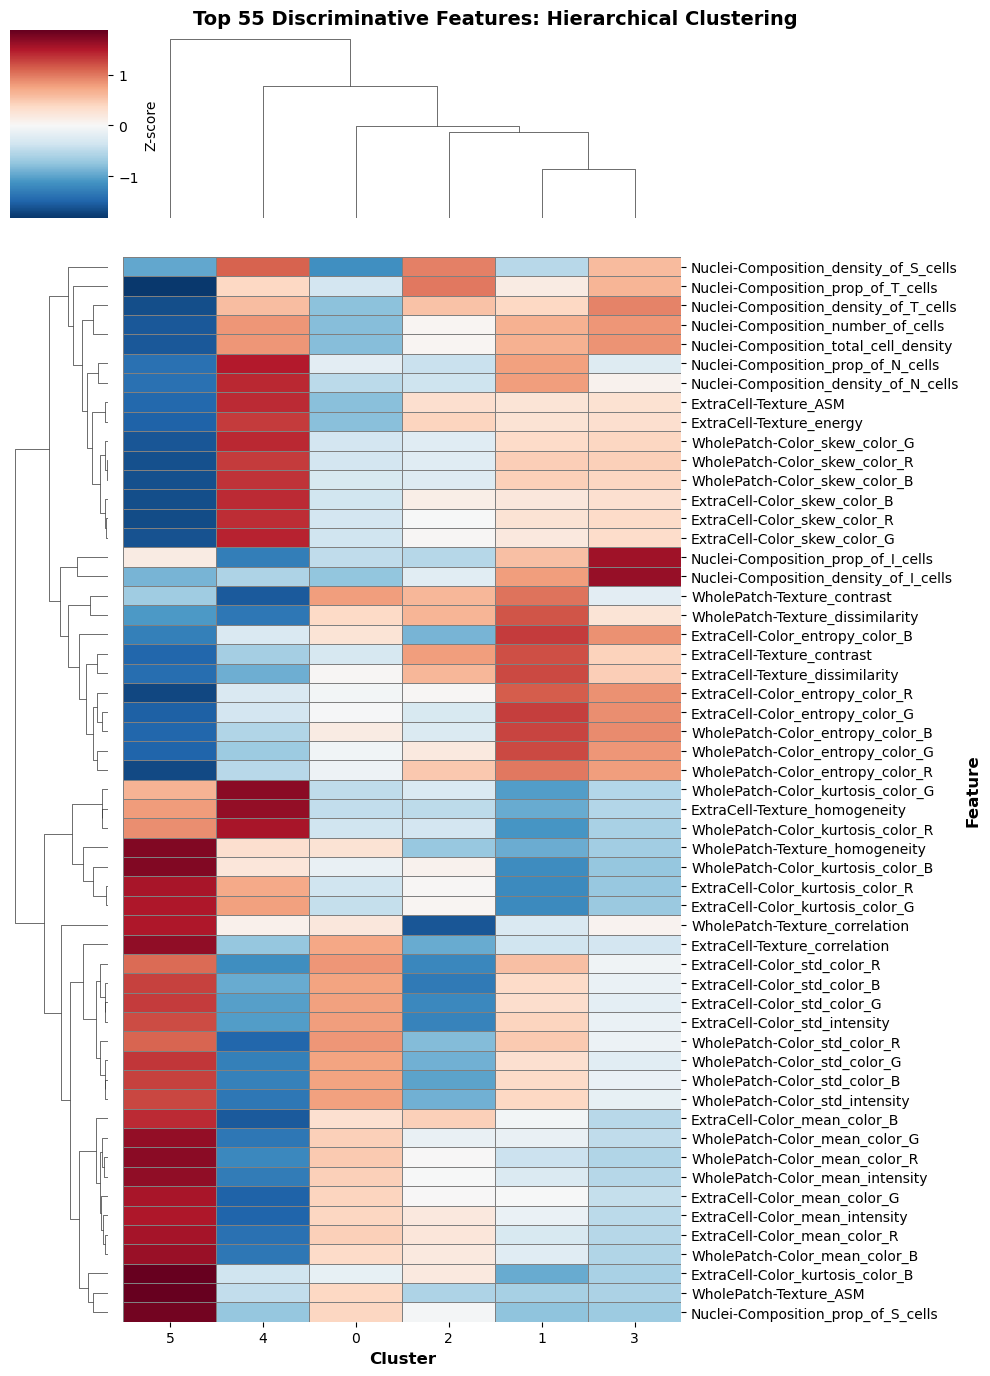

In [67]:
# Heatmap: Mean feature values per cluster (top 30 features)
top_n_heatmap = len(df_feature_stats[df_feature_stats['significant']])
top_features_heatmap = df_feature_stats.nsmallest(top_n_heatmap, 'p_value')['feature'].values

# Create pivot table: features x clusters
heatmap_data = []
for feature_name in top_features_heatmap:
    feature_data = ef_inv_long_clusters[ef_inv_long_clusters['feature'] == feature_name]
    cluster_means = feature_data.groupby('predicted_label')['value'].mean()
    heatmap_data.append(cluster_means)

df_heatmap = pd.DataFrame(heatmap_data, index=top_features_heatmap)

# Normalize by row (z-score) to see relative differences
df_heatmap_norm = df_heatmap.sub(df_heatmap.mean(axis=1), axis=0).div(df_heatmap.std(axis=1), axis=0)

# Clustered heatmap with dendrogram
g = sns.clustermap(df_heatmap_norm, 
                   cmap='RdBu_r', 
                   center=0,
                   figsize=(10, 14),
                   cbar_kws={'label': 'Z-score'},
                   linewidths=0.5, 
                   linecolor='gray',
                   row_cluster=True,  # Cluster features (rows)
                   col_cluster=True,  # Cluster patient groups (columns)
                   dendrogram_ratio=0.15,
                   cbar_pos=(0.02, 0.83, 0.03, 0.15))

g.ax_heatmap.set_xlabel('Cluster', fontsize=12, fontweight='bold')
g.ax_heatmap.set_ylabel('Feature', fontsize=12, fontweight='bold')
g.fig.suptitle(f'Top {top_n_heatmap} Discriminative Features: Hierarchical Clustering', 
               fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

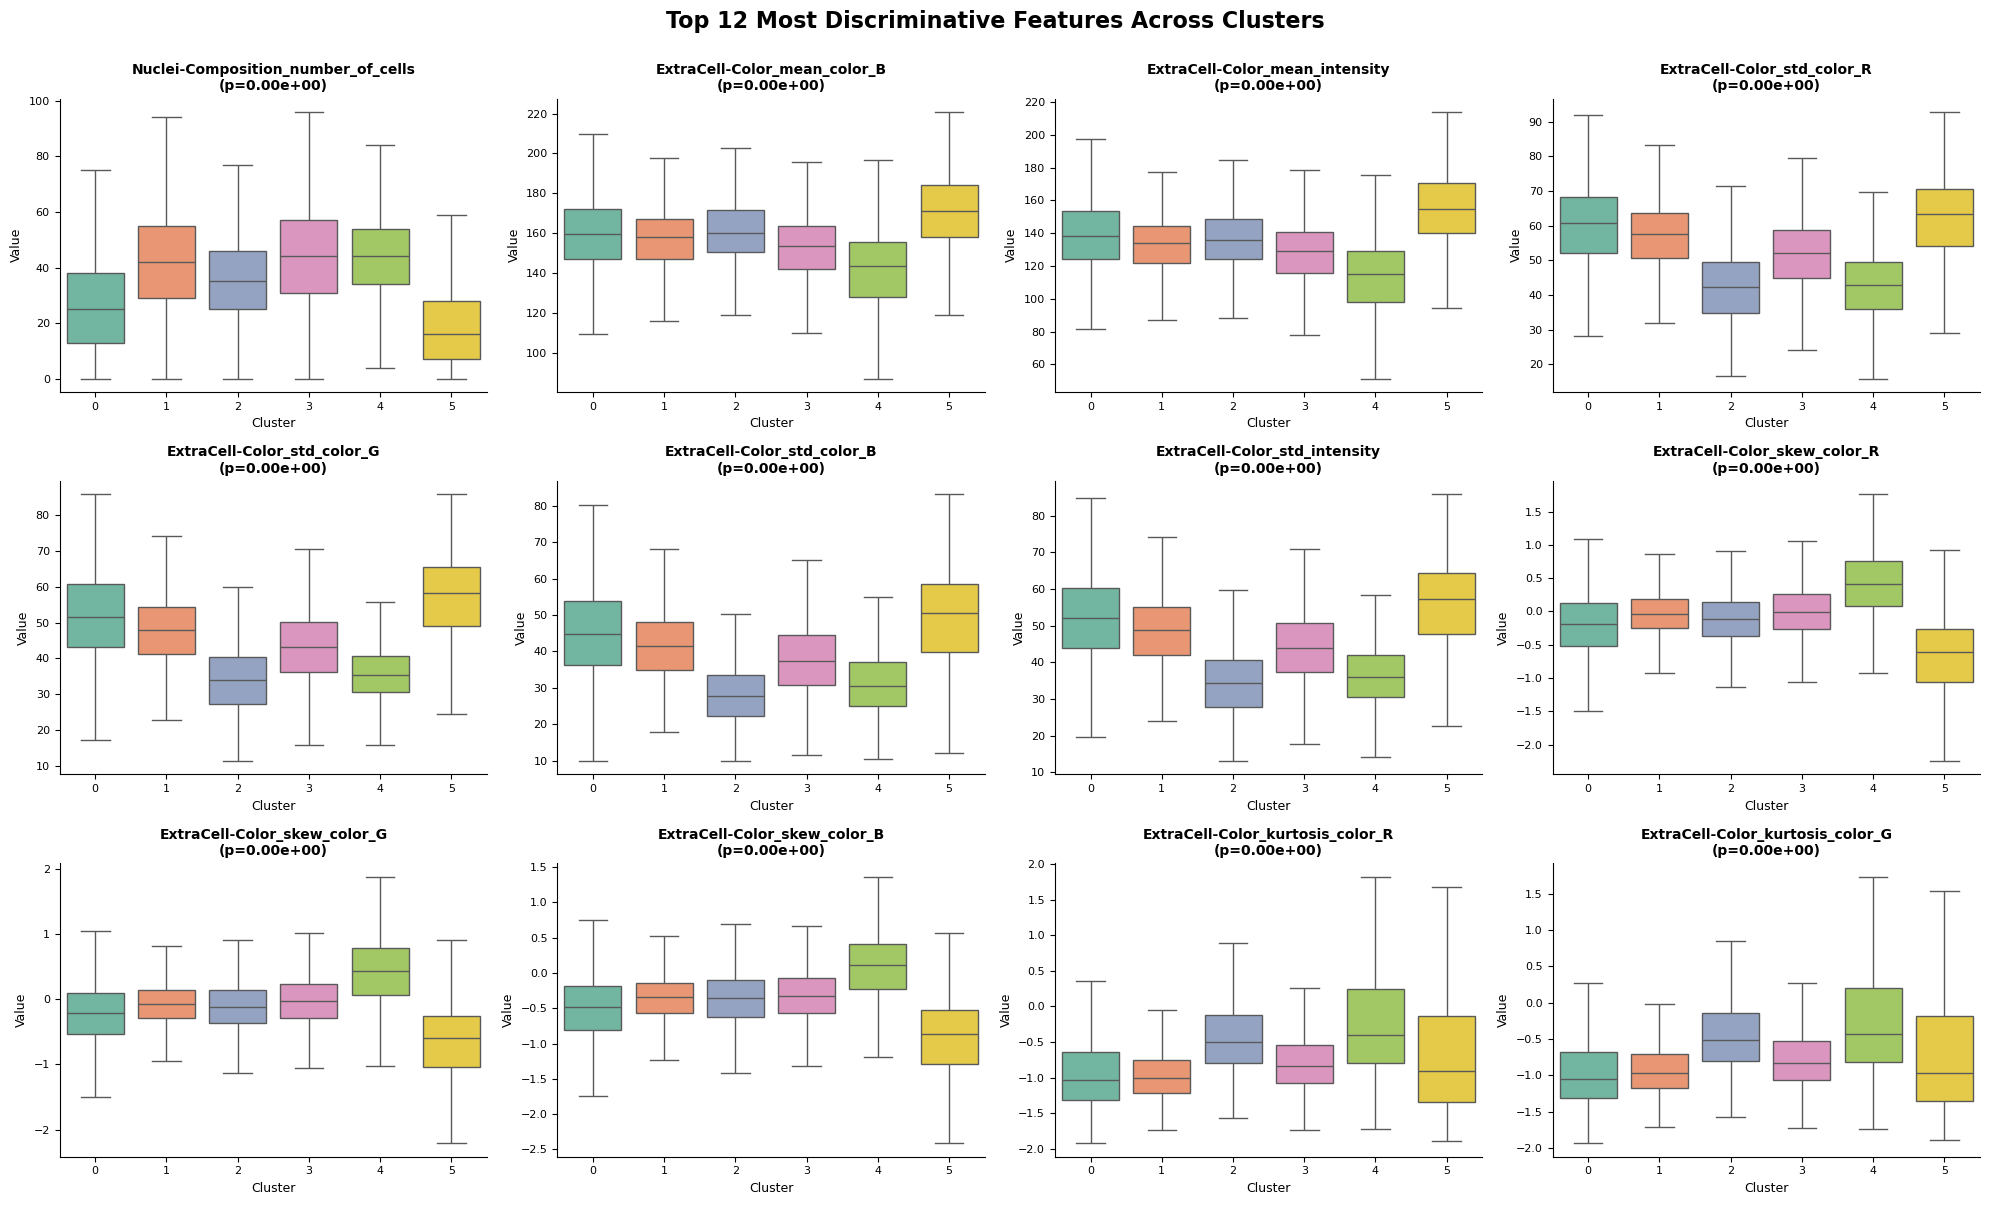

In [63]:
# Box plots for top 12 most discriminative features
import warnings
# remove futurewarnings
warnings.filterwarnings("ignore", category=FutureWarning)
top_n = 12
top_features_list = df_feature_stats.nsmallest(top_n, 'p_value')['feature'].values

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for idx, feature_name in enumerate(top_features_list):
    ax = axes[idx]
    feature_data = ef_inv_long_clusters[ef_inv_long_clusters['feature'] == feature_name]
    
    # Create box plot

    sns.boxplot(data=feature_data, x='predicted_label', y='value', ax=ax,
                palette='Set2', showfliers=False)
    
    # Get p-value for title
    p_val = df_feature_stats[df_feature_stats['feature'] == feature_name]['p_value'].values[0]
    
    ax.set_title(f'{feature_name}\n(p={p_val:.2e})', fontsize=10, fontweight='bold')
    ax.set_xlabel('Cluster', fontsize=9)
    ax.set_ylabel('Value', fontsize=9)
    ax.tick_params(labelsize=8)

plt.suptitle('Top 12 Most Discriminative Features Across Clusters', 
             fontsize=16, fontweight='bold', y=1.00)
sns.despine()
plt.tight_layout()
plt.show()

In [78]:

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

def get_pixel_annotation(spot_name, patches_info):
    info_patch = [patch for patch in patches_info if spot_name in patch["name"]][0]
    slide_name = info_patch["path_origin"].split("/")[-1].split(".")[0]
    annotated_slide = f"/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imageAnnotations/{slide_name}.png"
    annotated = Image.open(annotated_slide).convert("RGB").resize((9523, 9523))

    if "TNBC78" in spot_name:
        print("Rotating TNBC78")
        annotated = np.rot90(annotated, k=-1)

    if "TNBC92" in spot_name:
        print("Rotating TNBC92")
        annotated = np.rot90(annotated, k=2)

    # img_hd = Image.open(slide_hd)
    factor = 10 / 3
    patch_low_res_x = info_patch["start_width_origin"] / factor
    patch_low_res_y = info_patch["start_height_origin"] / factor
    patch_size = int(252 / factor)


    img_arr = np.array(annotated)
    # Calculate crop indices
    x_start = int(patch_low_res_x)
    y_start = int(patch_low_res_y)
    x_end = x_start + patch_size
    y_end = y_start + patch_size


    # Use numpy slicing to extract the region
    annot_patch = img_arr[y_start:y_end, x_start:x_end]

    return annot_patch


In [75]:
import gzip
import pickle

with gzip.open(config["patches_info_path"]) as f:
    patches_info = pickle.load(f)

In [ ]:
def count_annotation_colors(annot, max_display=50, show_plot=True, show_table=True):
    """
    Count pixels per RGB color in an annotation image.
    
    Parameters:
    -----------
    annot : numpy array or PIL image
        The annotation image to analyze
    max_display : int, optional (default=50)
        Maximum number of unique colors to display individually. 
        Colors beyond this are aggregated as "Other"
    show_plot : bool, optional (default=True)
        Whether to display the bar plot
    show_table : bool, optional (default=True)
        Whether to display the dataframe table
        
    Returns:
    --------
    dict
        Dictionary mapping hex colors to their percentage in the image
        Format: {'#rrggbb': percentage, ...}
    """
    from IPython.display import display
    
    arr = np.array(annot)  # ensure numpy array

    # Handle grayscale or alpha channel
    if arr.ndim == 2:
        arr = np.stack([arr] * 3, axis=-1)
    if arr.shape[2] == 4:
        arr = arr[:, :, :3]

    h, w, _ = arr.shape
    pixels = arr.reshape(-1, 3)

    # Count unique RGB tuples
    unique, counts = np.unique(pixels, axis=0, return_counts=True)
    rgb_tuples = [tuple(row) for row in unique]
    df_colors = pd.DataFrame({
        'rgb': rgb_tuples,
        'hex': ['#{:02x}{:02x}{:02x}'.format(r, g, b) for r, g, b in rgb_tuples],
        'count': counts
    })
    df_colors = df_colors.sort_values('count', ascending=False).reset_index(drop=True)
    df_colors['pct'] = df_colors['count'] / (h * w) * 100

    # If too many unique colors, keep top N and aggregate the rest as "Other"
    if len(df_colors) > max_display:
        top = df_colors.iloc[:max_display].copy()
        other = df_colors.iloc[max_display:].agg({'count': 'sum', 'pct': 'sum'})
        other_row = {'rgb': None, 'hex': '#808080', 'count': int(other['count']), 'pct': float(other['pct'])}
        df_plot = pd.concat([top, pd.DataFrame([other_row])], ignore_index=True)
    else:
        df_plot = df_colors

    print(f"Image size: {h} x {w} = {h*w} pixels")
    
    if show_table:
        display(df_plot[['hex', 'count', 'pct']])

    # Plot colored bars matching the actual colors
    if show_plot:
        fig, ax = plt.subplots(figsize=(8, max(3, 0.25 * len(df_plot))))
        bar_colors = df_plot['hex'].tolist()
        ax.bar(range(len(df_plot)), df_plot['count'], color=bar_colors)
        ax.set_xticks(range(len(df_plot)))
        ax.set_xticklabels(df_plot['hex'].tolist(), rotation=90, fontsize=8)
        ax.set_ylabel('Pixel count')
        ax.set_title('Pixel counts by color (hex shown on x-axis)')
        plt.tight_layout()
        plt.show()
    
    # Return dictionary with all colors (not just top N)
    return dict(zip(df_colors['hex'], df_colors['pct']))


# Example usage


Image size: 75 x 75 = 5625 pixels


,hex,count,pct
0,#e9d1bb,2165,38.488889
1,#000000,2133,37.920000
2,#ff9980,1191,21.173333
3,#40e5f6,136,2.417778


In [ ]:
annot = get_pixel_annotation("TNBC11_CN6_C1_patch002", patches_info)
color_dict = count_annotation_colors(annot, show_plot=False, show_table=False)

Image size: 75 x 75 = 5625 pixels


,hex,count,pct
0,#e9d1bb,2165,38.488889
1,#000000,2133,37.920000
2,#ff9980,1191,21.173333
3,#40e5f6,136,2.417778


In [88]:
df

,predicted_label,label
TNBC11_CN6_C1_patch002,2,NaN
TNBC11_CN6_C1_patch004,0,NaN
TNBC11_CN6_C1_patch010,2,NaN
TNBC11_CN6_C1_patch012,2,NaN
TNBC11_CN6_C1_patch013,2,NaN
...,...,...
TNBC9_spot50x16,1,NaN
TNBC9_spot50x18,1,NaN
TNBC9_spot52x18,0,NaN
TNBC9_spot6x52,3,NaN
